In [14]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler # 新增 MinMaxScaler
from sklearn.manifold import TSNE
import re
import matplotlib.pyplot as plt
import seaborn as sns
#from sklearn.metrics import pairwise_distances, cosine_similarity
from sklearn.metrics import pairwise_distances
from sklearn.metrics.pairwise import cosine_similarity
from dash import Dash, dcc, html, Input, Output
import plotly.express as px
import gensim.downloader as api

In [19]:
data = {
    'Class': ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H'],
    'Drink': ['Coke', 'Pepsi', 'Sprite', '7Up', 'Cappuccino', 'Espresso', 'Latte','Mocha'],
    'Rank': [8, 7, 6, 5, 4, 3, 2, 1],
    'Amount(N(μ,σ))': ['N(100, 200)', 'N(200, 10)', 'N(200, 10)', 'N(400, 100)', 'N(700, 10)', 'N(700, 10)', 'N(800, 300)','(900, 400)'],
    'Quantity': ['Random(500, 1000)', 'Random(500, 1000)', 'Random(500, 1000)', 'Random(500, 1000)', 'Random(1, 500)', 'Random(1, 500)', 'Random(1, 500)', 'Random(1, 500)'],
    'Count': [100, 200, 100, 400, 400, 200, 100, 100]
}
df_initial = pd.DataFrame(data) # 更名為 df_initial 以避免與後續生成的 df 混淆

In [31]:
# 1. 生成詳細數據集
data = []
for class_label in df_initial['Class'].unique():
    class_data = df_initial[df_initial['Class'] == class_label]
    for _, row in class_data.iterrows():
        drink, rank, count, class_orig = row['Drink'], row['Rank'], row['Count'], row['Class'] # 新增 class_orig
        mu, sigma = map(int, re.findall(r'\d+', row['Amount(N(μ,σ))']))
        min_val, max_val = map(int, re.findall(r'\d+', row['Quantity']))

        amounts = np.random.normal(mu, sigma, count)
        quantities = np.random.uniform(min_val, max_val, count)

        for i in range(count):
            data_point = {
                'Class': class_orig, # 使用原始的 Class 標籤
                'Drink': drink,
                'Rank': rank,
                'Amount': amounts[i],
                'Quantity': quantities[i]
            }
            data.append(data_point)

df = pd.DataFrame(data)
print("生成的詳細數據集 df.head():")
print(df)
print("-" * 50)

生成的詳細數據集 df.head():
     Class  Drink  Rank       Amount    Quantity
0        A   Coke     8  -140.028960  774.985814
1        A   Coke     8   318.755235  757.997651
2        A   Coke     8  -101.136205  713.600572
3        A   Coke     8   -67.477304  543.120963
4        A   Coke     8  -104.616745  584.091803
...    ...    ...   ...          ...         ...
1595     H  Mocha     1   995.692659  117.574864
1596     H  Mocha     1  1042.645044  306.298079
1597     H  Mocha     1   958.290453  129.574199
1598     H  Mocha     1   840.567351  280.443645
1599     H  Mocha     1   915.139911  479.818246

[1600 rows x 5 columns]
--------------------------------------------------


--- 方法一：基於 Drink 詞向量的 t-SNE ---
drink_vectors 的樣本數量： 8


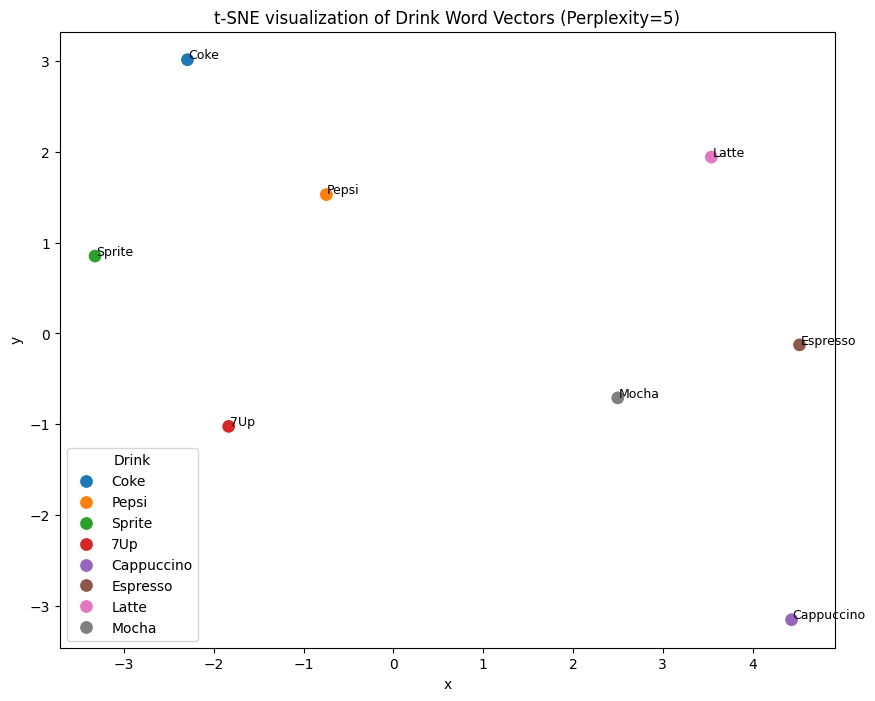

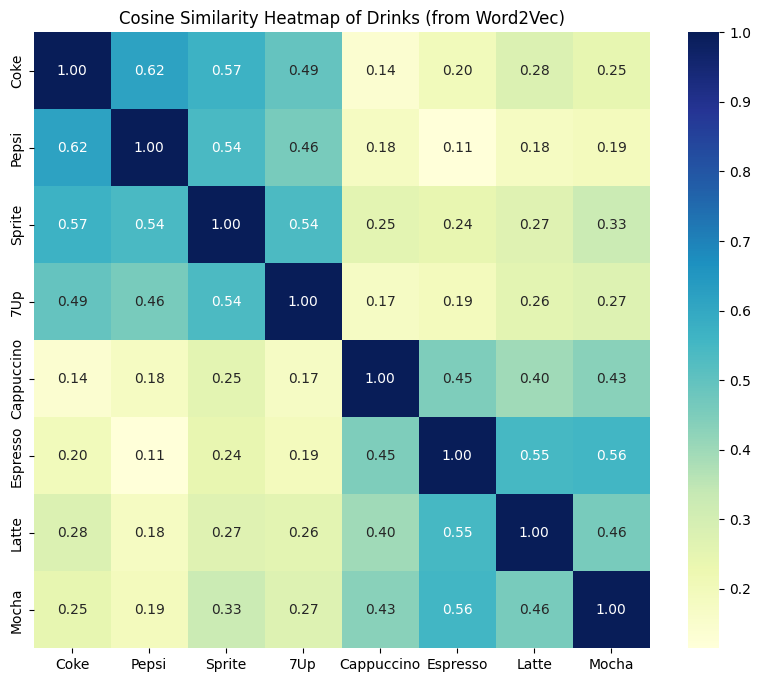

In [ ]:
# --- 方法一：基於 Drink 詞向量的 t-SNE (語義相似度) ---
print("--- 問題一：基於 Drink 詞向量的 t-SNE ---")

try:
    model = api.load("word2vec-google-news-300")
except Exception as e:
    print(f"載入 Word2Vec 模型時發生錯誤：{e}。請確保網路連線良好。")
    print("為演示目的，使用一個簡單的模擬模型。")
    # 模擬一個簡單的模型以繼續執行
    from gensim.models import KeyedVectors
    model = KeyedVectors(vector_size=300)
    # 添加一些飲料的向量（這裡只是示例，實際中會是模型訓練出來的向量）
    # 確保所有 unique_drinks 都有對應的向量，否則會在 drink_vectors 建立時出錯
    unique_drinks_temp = df['Drink'].unique().tolist()
    for d in unique_drinks_temp:
        if d not in model.key_to_index:
            model.add_vectors([d], [np.random.rand(300) * 2 - 1]) # 隨機向量

unique_drinks = df['Drink'].unique().tolist()
# 確保只有模型中有的詞才被選入
drinks_in_model = [drink for drink in unique_drinks if drink in model.key_to_index]
drink_vectors = np.array([model[drink] for drink in drinks_in_model])

print("drink_vectors 的樣本數量：", drink_vectors.shape[0])

missing_drinks = [drink for drink in unique_drinks if drink not in model.key_to_index]
if missing_drinks:
    print("以下飲料不在 GoogleNews 詞彙表中：", missing_drinks)

# 調整 perplexity 以避免 ValueError
n_samples_wordvec = drink_vectors.shape[0]
perplexity_wordvec = min(5, max(2, n_samples_wordvec - 1)) # perplexity 需小於樣本數，且至少為 2

if n_samples_wordvec > 1: # 確保有足夠的樣本進行 t-SNE
    tsne_wordvec = TSNE(n_components=2, perplexity=perplexity_wordvec, random_state=42)
    tsne_results_wordvec = tsne_wordvec.fit_transform(drink_vectors)

    scaling_factor = 0.1
    tsne_results_wordvec = tsne_results_wordvec * scaling_factor

    tsne_df_wordvec = pd.DataFrame(tsne_results_wordvec, columns=['x', 'y'])
    tsne_df_wordvec['Drink'] = drinks_in_model # 使用已篩選的飲料列表

    plt.figure(figsize=(10, 8))
    sns.scatterplot(data=tsne_df_wordvec, x='x', y='y', hue='Drink', palette='tab10', s=100)
    for i, row in tsne_df_wordvec.iterrows():
        plt.text(row['x']+0.01, row['y']+0.01, row['Drink'], fontsize=9)
    plt.title(f't-SNE visualization of Drink Word Vectors (Perplexity={perplexity_wordvec})')
    plt.show()

    # 餘弦相似度熱力圖 (針對詞向量)
    similarity_matrix = cosine_similarity(drink_vectors)
    similarity_df = pd.DataFrame(similarity_matrix, index=drinks_in_model, columns=drinks_in_model)

    plt.figure(figsize=(10, 8))
    sns.heatmap(similarity_df, annot=True, cmap='YlGnBu', square=True, fmt=".2f") # 格式化顯示兩位小數
    plt.title('Cosine Similarity Heatmap of Drinks (from Word2Vec)')
    plt.show()
else:
    print("用於 Word2Vec t-SNE 的飲料詞向量數量不足，無法進行視覺化。")


--- 方法二：1-of-k 編碼 + 數值屬性的 t-SNE ---


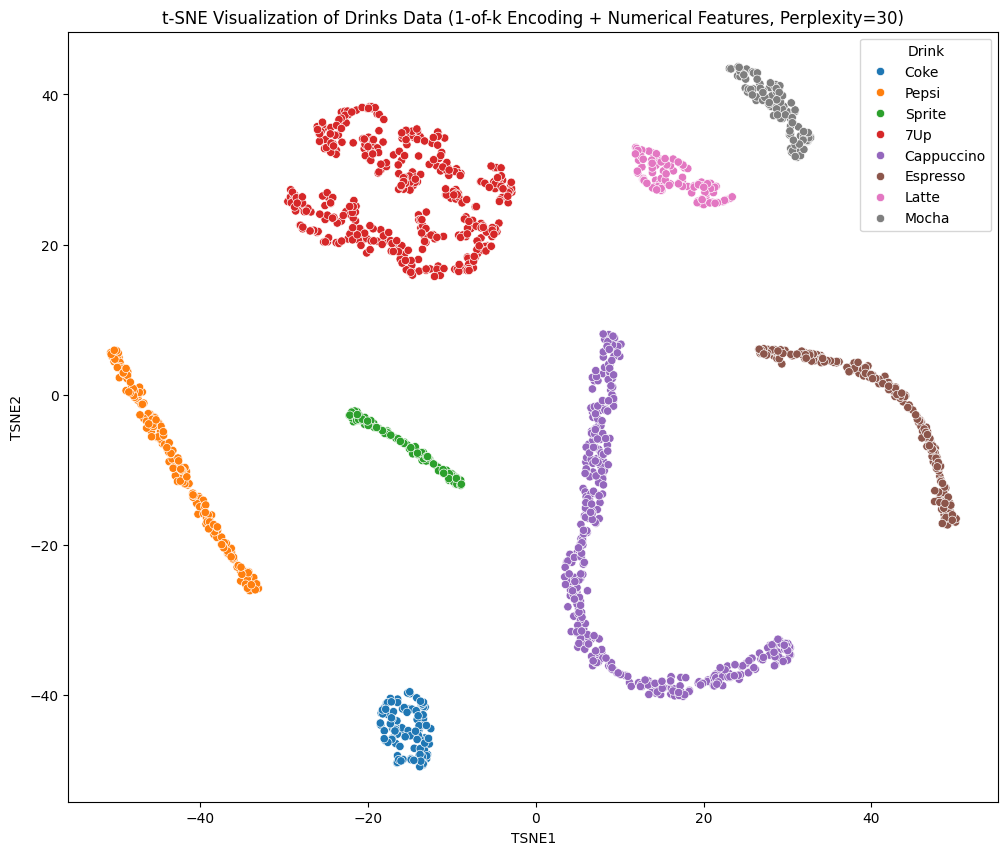

In [ ]:
# # **比較方法一：1-of-k 編碼 + 數值屬性**

# #這個部分使用獨熱編碼處理 `Drink` 屬性，並結合標準化後的數值屬性。

# print("\n--- 問題二：1-of-k 編碼 + 數值屬性的 t-SNE ---")

# # 複製 df 以避免修改原始數據
# df_method2 = df.copy()

# # 獨熱編碼 (1-of-k 編碼)
# encoder = OneHotEncoder(sparse_output=False) # sparse_output=False 確保輸出是密集數組
# encoded_drinks = encoder.fit_transform(df_method2[['Drink']])
# encoded_drinks_df = pd.DataFrame(encoded_drinks, columns=encoder.get_feature_names_out(['Drink']))
# df_method2 = pd.concat([df_method2.reset_index(drop=True), encoded_drinks_df.reset_index(drop=True)], axis=1)

# # 標準化數值特徵
# scaler = StandardScaler()
# numeric_features = ['Rank', 'Amount', 'Quantity']
# df_method2[numeric_features] = scaler.fit_transform(df_method2[numeric_features])

# # t-SNE 輸入
# tsne_input_method2 = df_method2[numeric_features + list(encoded_drinks_df.columns)]

# # 調整 perplexity
# n_samples_method2 = tsne_input_method2.shape[0]
# perplexity_method2 = min(30, max(5, n_samples_method2 - 1)) # 常規的 perplexity 範圍，但仍需小於樣本數

# if n_samples_method2 > 1: # 確保有足夠的樣本進行 t-SNE
#     tsne_method2 = TSNE(n_components=2, perplexity=perplexity_method2, random_state=42)
#     tsne_results_method2 = tsne_method2.fit_transform(tsne_input_method2)

#     df_tsne_method2 = pd.DataFrame(tsne_results_method2, columns=['TSNE1', 'TSNE2'])
#     df_tsne_method2['Drink'] = df_method2['Drink'] # 使用原始的 Drink 標籤

#     plt.figure(figsize=(12, 10))
#     sns.scatterplot(
#         x='TSNE1', y='TSNE2',
#         hue='Drink',
#         palette=sns.color_palette('tab10', len(df_method2['Drink'].unique())), # 使用 tab10 顏色避免過多類別顏色混亂
#         data=df_tsne_method2,
#         legend='full',
#         alpha=1 # 降低透明度，因為點很多
#     )
#     # 由於點很多，可能不適合在每個點上標註文字，可以只標註少數代表點或使用互動圖表
#     # for i, row in df_tsne_method2.sample(min(50, len(df_tsne_method2))).iterrows(): # 隨機抽樣部分點進行標註
#     #     plt.text(row['TSNE1']+0.01, row['TSNE2']+0.01, row['Drink'], fontsize=7)
#     plt.title(f't-SNE Visualization of Drinks Data (1-of-k Encoding + Numerical Features, Perplexity={perplexity_method2})')
#     plt.show()
# else:
#     print("用於 1-of-k 方法的樣本數量不足，無法進行視覺化。")



--- 方法三：考慮屬性值的相似度 (人工定義 Class 不相似度) ---


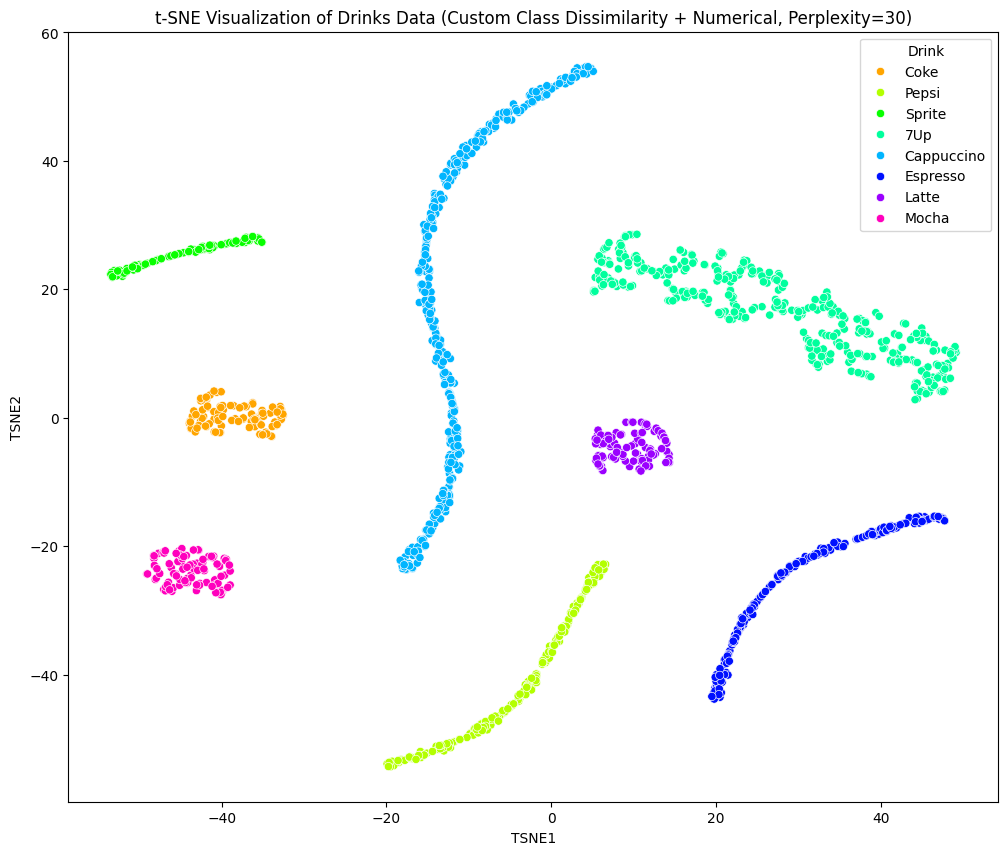

In [ ]:
# **比較方法二：考慮屬性值的相似度 (人工定義 Class 不相似度)**

#這個部分將為 `Class` 屬性定義人工不相似度，並與數值屬性結合。

print("\n--- 問題三：考慮屬性值的相似度 (人工定義 Class 不相似度) ---")

# 複製 df 以避免修改原始數據
df_method3 = df.copy()

# 數值特徵正規化 (MinMaxScaler 適合距離計算)
scaler_minmax = MinMaxScaler()
numeric_features = ['Rank', 'Amount', 'Quantity']
df_method3[numeric_features] = scaler_minmax.fit_transform(df_method3[numeric_features])

# 計算數值特徵的歐幾里德距離 (作為不相似度)
numeric_distances = pairwise_distances(df_method3[numeric_features], metric='euclidean')

# --- 定義 Class 屬性的人工不相似度矩陣 ---
unique_classes = df_method3['Class'].unique()
class_to_id = {cls: i for i, cls in enumerate(unique_classes)}
class_ids = df_method3['Class'].map(class_to_id).values

n_samples = df_method3.shape[0]
class_dissimilarity_matrix = np.zeros((n_samples, n_samples))

for i in range(n_samples):
    for j in range(i, n_samples):
        if class_ids[i] == class_ids[j]:
            # 同類品項的不相似度值為 2
            class_dissimilarity_matrix[i, j] = 2
        else:
            # 不同類品項的不相似度值為 4
            class_dissimilarity_matrix[i, j] = 4
        class_dissimilarity_matrix[j, i] = class_dissimilarity_matrix[i, j] # 矩陣對稱

# --- 結合所有屬性的不相似度矩陣 ---
# 這是一個簡單的加權組合。您可以根據需求調整權重或組合方式。
# 我們假設 Class 屬性對聚類的重要性與數值屬性同等。
# 這裡，我們將數值距離和類別不相似度直接相加。
# 由於兩個矩陣的值範圍可能不同，正規化它們可能更合適，但為了符合「同類2，不同類4」的設定，我們直接使用。
# 更嚴謹的做法會是先將兩個距離矩陣都縮放到類似的範圍（例如0-1），然後再加權平均。
# 但這裡我們依照提示，直接使用2和4的設定。

# 如果數值距離範圍非常大，可能需要對其進行縮放，使其與 class_dissimilarity_matrix 的範圍相近
# 例如：numeric_distances_scaled = MinMaxScaler().fit_transform(numeric_distances) * 4 # 縮放到 0-4
# 但為了符合提示，我們直接相加。
total_dissimilarity_matrix = numeric_distances + class_dissimilarity_matrix

# --- 使用 t-SNE 的 precomputed 模式 ---
n_samples_method3_tsne = total_dissimilarity_matrix.shape[0]
perplexity_method3 = min(30, max(5, n_samples_method3_tsne - 1)) # 調整 perplexity

if n_samples_method3_tsne > 1: # 確保有足夠的樣本進行 t-SNE
    #tsne_method3 = TSNE(n_components=2, perplexity=perplexity_method3, random_state=42, metric='precomputed')
    tsne_method3 = TSNE(n_components=2, perplexity=perplexity_method3, random_state=42, metric='precomputed', init='random')
    tsne_results_method3 = tsne_method3.fit_transform(total_dissimilarity_matrix)

    df_tsne_method3 = pd.DataFrame(tsne_results_method3, columns=['TSNE1', 'TSNE2'])
    df_tsne_method3['Drink'] = df_method3['Drink']
    df_tsne_method3['Class'] = df_method3['Class'] # 新增 Class 欄位以便觀察聚類

    plt.figure(figsize=(12, 10))
    sns.scatterplot(
        x='TSNE1', y='TSNE2',
        hue='Drink', # 根據 Class 著色，更容易觀察 Class 的聚類效果
        palette=sns.color_palette('hsv', len(df_method3['Class'].unique())),
        data=df_tsne_method3,
        legend='full',
        alpha=1
    )
    plt.title(f't-SNE Visualization of Drinks Data (Custom Class Dissimilarity + Numerical, Perplexity={perplexity_method3})')
    plt.show()
     #--- 推薦的繪圖方法：保持按 Class 分色，並在圖上標註文字 ---   
    
else:
    print("用於自定義相似度方法的樣本數量不足，無法進行視覺化。")


In [42]:

# **Dash 互動式應用**

#請注意，Dash 應用仍只顯示**第一個 t-SNE 圖 (基於詞向量的圖)**。若要讓它顯示其他圖表，您需要新增下拉選單或按鈕來切換圖表。

app = Dash(__name__)

app.layout = html.Div([
    html.H1("飲料數據 t-SNE 互動式視覺化"),
    html.Div([
        html.Label("選擇 t-SNE 視覺化類型:"),
        dcc.Dropdown(
            id='tsne-type-dropdown',
            options=[
                {'label': '飲料詞向量 (語義相似度)', 'value': 'word2vec'},
                {'label': '1 of k', 'value': 'one_hot'},
                {'label': '自定義 Class 不相似度 + 數值特徵', 'value': 'custom_class'}
            ],
            value='word2vec', # 預設顯示詞向量圖
            clearable=False,
            style={'width': '50%'}
        )
    ]),
    dcc.Graph(id='tsne-plot', config={'scrollZoom': True, 'displayModeBar': True}, style={'height': '100vh', 'width': '100vh'}),
    html.H3("選取數據詳細資訊:"),
    html.Div(id='selected-data', style={'whiteSpace': 'pre-wrap', 'maxHeight': '300px', 'overflowY': 'scroll', 'border': '1px solid lightgray', 'padding': '10px'})
])

@app.callback(
    Output('tsne-plot', 'figure'),
    Input('tsne-plot', 'selectedData'), # 監聽圖表選擇事件
    Input('tsne-type-dropdown', 'value') # 監聽下拉選單的值
)
def update_graph(selectedData, selected_type):
    fig = px.scatter() # 初始化一個空的圖表

    if selected_type == 'word2vec':
        if n_samples_wordvec > 1:
            fig = px.scatter(tsne_df_wordvec, x='x', y='y', text='Drink', title='t-SNE Visualization of Drink Word Vectors')
        else:
            fig.update_layout(title_text="詞向量 t-SNE 數據不足，無法顯示。")
    elif selected_type == 'one_hot':
        if n_samples_method2 > 1:
            # 這裡使用 df_tsne_method2，並且直接顯示 Drink 標籤
            fig = px.scatter(df_tsne_method2, x='TSNE1', y='TSNE2', color='Drink', title='t-SNE: 1-of-k + Numerical Features')
        else:
            fig.update_layout(title_text="1-of-k t-SNE 數據不足，無法顯示。")
    elif selected_type == 'custom_class':
        if n_samples_method3_tsne > 1:
            # 這裡使用 df_tsne_method3，並以 Class 著色
            fig = px.scatter(df_tsne_method3, x='TSNE1', y='TSNE2', color='Drink', title='t-SNE: Custom Class Dissimilarity + Numerical Features')
        else:
            fig.update_layout(title_text="自定義 Class 相似度 t-SNE 數據不足，無法顯示。")
    
    fig.update_traces(marker=dict(size=10, opacity=0.6)) # 調整點的大小和透明度
    fig.update_layout(hovermode="closest") # 讓鼠標懸停更容易選取點

    # 處理選取點的邏輯
    if selectedData and selected_type != 'word2vec': # 只有當選取了點且不是詞向量圖時才突出顯示
        # 對於非詞向量圖，需要根據 x, y 座標來找原始點，而不是 text
        selected_points = selectedData['points']
        # 提取選取點的索引或座標
        selected_indices = [p['pointIndex'] for p in selected_points]
        
        # 根據不同的圖表類型從正確的 DataFrame 獲取資料點
        if selected_type == 'one_hot':
            current_df = df_tsne_method2
            hover_name_col = 'Drink'
        elif selected_type == 'custom_class':
            current_df = df_tsne_method3
            hover_name_col = 'Class' # 或 'Drink' 取決於你想在選取時顯示什麼

        if not current_df.empty:
            # 在原圖基礎上添加選取的點，並修改顏色
            fig.add_trace(px.scatter(current_df.iloc[selected_indices], 
                                    x=fig.data[0].x[selected_indices], 
                                    y=fig.data[0].y[selected_indices],
                                    color_discrete_sequence=['red']).data[0])
            fig.update_traces(marker=dict(size=12, color='red', line=dict(width=2, color='DarkSlateGrey')), selector=dict(mode='markers'))

    return fig


@app.callback(
    Output('selected-data', 'children'),
    Input('tsne-plot', 'selectedData'),
    Input('tsne-type-dropdown', 'value')
)
def display_selected_data(selectedData, selected_type):
    if selectedData:
        selected_points = selectedData['points']
        if selected_type == 'word2vec':
            # 詞向量圖的 hover_name 是 'Drink'
            selected_items = [point['text'] for point in selected_points]
            selected_df_display = df[df['Drink'].isin(selected_items)].drop_duplicates(subset=['Drink'])
        elif selected_type == 'one_hot':
            # 1-of-k 和自定義相似度圖的 pointIndex 對應 df 的行索引
            selected_indices = [point['pointIndex'] for point in selected_points]
            selected_df_display = df.iloc[selected_indices]
        elif selected_type == 'custom_class':
            selected_indices = [point['pointIndex'] for point in selected_points]
            selected_df_display = df.iloc[selected_indices]
        
        # 限制顯示的行數，避免過長
        if len(selected_df_display) > 20:
            return selected_df_display.head(20).to_string() + "\n...\n(顯示前20行，共 {} 行)".format(len(selected_df_display))
        return selected_df_display.to_string()
    return "No points selected"

if __name__ == '__main__':
    app.run(debug=True)